***

Profesor: Gonzalo A. Ruz, PhD

Curso: Aprendizaje Automático

***

In [1]:
# Global imports and settings
import keras
import tensorflow
print("Using Keras",keras.__version__)
print("Using Tensorflow",tensorflow.__version__)
%matplotlib inline

Using Keras 2.8.0
Using Tensorflow 2.8.2


In [2]:
# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

# Clase: Usando redes neuronales

### Contenido
* Resolver problemas básicos de clasificación y regresión
* Manejo de datos textuales
* Selección de modelo (y sobreajuste)

## Resolver problemas básicos
* Clasificación binaria (de reseñas de películas)
* Clasificación multiclase (de temas de noticias)
* Regresión (de precios de la vivienda)

Ejemplos tomados del libro *Deep Learning with Python*, by *François Chollet*

### Componentes de las redes neuronales (repaso)
* *Capas* de nodos: transformar un tensor de entrada en un tensor de salida
    - Cada una con (un tensor de) pesos que se ajustarán a los datos de entrenamiento
    - Muchos tipos: densas, convolucionales, recurrentes, ...
* *Función de pérdida*: Mide si el modelo se ajusta a los datos de entrenamiento
* *Optimizador*: Cómo actualizar la red, por ej. SGD

![](https://drive.google.com/uc?id=1gjlHh9Xf3LA5YV27vba-ATV84vKtkh_S)

### Clasificación binaria
* Conjunto de datos: 50 000 revisiones de [IMDB](https://www.imdb.com/), etiquetadas como positivas (1) o negativas (0)
    - Incluido en Keras, con una división de entrenamiento-prueba de 50/50
* Cada fila es una revisión, con solo las 10 000 palabras más frecuentes retenidas
* Cada palabra se reemplaza por un *índice de palabra* (ID de palabra)

In [3]:
from tensorflow.keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))

17473536/17464789 [==============================] - 0s 0us/step
Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
1654784/1641221 [==============================] - 0s 0us/step
Original review:  ? this film was just brilliant casting location scenery story


In [4]:
train_labels[0]

1

#### Preprocesamiento
* No podemos ingresar listas de valor categórico en una red neuronal, necesitamos crear tensores
* One-hot-encoding:
    -  10000 características, '1' si aparece la palabra
* Word embeddings (word2vec):
    - Asigne cada palabra a un vector denso que la represente (su *embedding*)
    - Capa de *embedding*: capa previamente entrenada que busca el embedding en un diccionario 
    - Convierte el tensor 2D de índices de palabras (relleno con ceros) en tensor 3D de embeddings
* Hagamos One-Hot-Encoding por ahora.
* También vectorizar las etiquetas: de 0/1 a punto flotante.
    - La clasificación binaria funciona con un nodo de salida

``` python
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
```

In [5]:
# Custom implementation of one-hot-encoding
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print("Encoded review: ", train_data[0][0:10])
print("One-hot-encoded review: ", x_train[0][0:10])

# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print("Label: ", y_train[0])

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
One-hot-encoded review:  [0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
Label:  1.0


#### Construyendo la red
* Podemos resolver este problema utilizando una red de capas *Dense* y la función de activación *ReLU*.
* Cuantas capas? ¿Cuántas unidades ocultas por capa?
    - Comience con 2 capas de 16 unidades ocultas cada una
    - Lo optimizaremos pronto
* Capa de salida: unidad única con función de activación *sigmoid*
    - Cerca de 1: revisión positiva, cerca de 0: revisión negativa
    
``` python
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
```

#### Cross-entropy loss
*  Hemos visto *cross-entropy loss* (o *log loss*) para $C$ clases anteriormente
    - Mide qué tan similares son las distribuciones de probabilidad real y predicha
    - Computar cross-entropy $H(y,\hat{y})$ entre $y$ verdadero e $\hat{y}$ predicha
    - Sumar sobre todas las muestras de entrenamiento
$$ H(y,\hat{y}) = - \sum_{c=1}^C y_c \log(\hat{y}_c)$$

* Para la clasificación binaria, esto se simplifica a
$$ - \sum_{c=0,1} y_c \log(\hat{y}_c) = −(y \log(\hat{y})+ (1−y) \log(1−\hat{y}))$$

Cross-entropy loss

![](https://drive.google.com/uc?id=1gOiYApti5QohLFdoLR6gT_ZWLsd4wvT4)

In [6]:
from tensorflow.keras import models
from tensorflow.keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Para tener más control, puede crear explícitamente el optimizador, la pérdida y las métricas:

``` python
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
```

#### Selección de modelo
* ¿Cuántas épocas necesitamos para entrenar?
* Tome un conjunto de validación de 10 000 muestras del conjunto de entrenamiento
* Entrene la red neuronal y rastree la pérdida después de cada iteración en el conjunto de validación
    - Esto se devuelve como un objeto `History` por la función `fit()` 
* Empezamos con 20 épocas en minibatches de 512 muestras

``` python
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))
```

In [7]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))

Ahora podemos recuperar y visualizar la pérdida en los datos de validación
* La pérdida de entrenamiento sigue disminuyendo debido al descenso del gradiente.
* La pérdida de validación alcanza su punto máximo después de algunas épocas, después de las cuales el modelo comienza a sobreajustarse

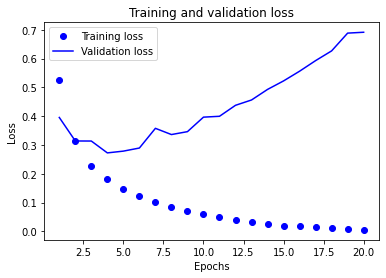

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

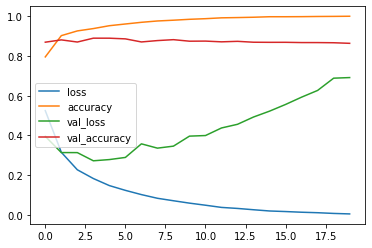

In [9]:
# Alternative plotting code
import pandas as pd

pd.DataFrame(history.history).plot();

También podemos visualizar el accuracy, con hallazgos similares

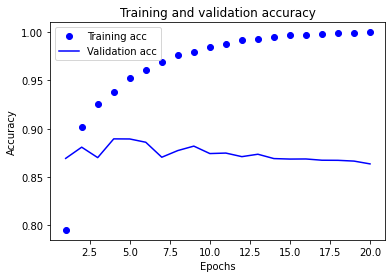

In [10]:
plt.clf()   # clear figure
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Parada anticipada
Una técnica sencilla para evitar el sobreajuste es utilizar el conjunto de validación para 'ajustar' el número óptimo de épocas
* En este caso, podríamos detenernos después de 4 épocas.

``` python
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=0)
result = model.evaluate(x_test, y_test)
```

In [11]:
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=0)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

782/782 [==============================] - 3s 3ms/step - loss: 0.4795 - accuracy: 0.8598
Loss: 0.4795, Accuracy:  0.8598


#### Predicciones
Por curiosidad, veamos algunas predicciones:

In [ ]:
predictions = model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 16: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[16]]))
print("Predicted positiveness: ", predictions[16])

#### Qué cosas recordar de este ejemplo
* Las redes neuronales requieren mucho procesamiento previo para crear tensores
* Capas *Dense* con activaciones ReLU pueden resolver una amplia gama de problemas
* La clasificación binaria se puede hacer con una capa Dense con una unidad en la salida con activación sigmoid, y binary cross-entropy loss
* Las redes neuronales se sobreajustan fácilmente
* Muchas opciones de diseño tienen un efecto sobre el accuracy y el sobreajuste. Probar:
    - 1 o 3 capas ocultas
    - más o menos unidades ocultas (ej. 64)
    - MSE loss en vez de binary cross-entropy
    - activación `tanh` en vez de `ReLU`

### Clasificación de varias clases o multi-clase (clasificación de temas)
* Dataset: 11 000 noticias, 46 temas
    - Incluido en Keras, con una división de entrenamiento-prueba de 50/50
* Cada fila es una noticia, con solo las 10 000 palabras más frecuentes retenidas
* Cada palabra se reemplaza por un *índice de palabra* (ID de palabra)

In [13]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print("News wire: ",decoded_newswire)
print("Encoded: ", train_data[0][0:20])
print("Topic: ",train_labels[0])

565248/550378 [==============================] - 0s 0us/step
News wire:  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
Encoded:  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7]
Topic:  3


#### Preparando los datos
* Tenemos que volver a vectorizar los datos (usando one-hot-encoding)
* También tenemos que vectorizar las etiquetas de salida, también usando one-hot-encoding
    - Podemos usar de Keras `to_categorical` nuevamente
    - Esto produce un vector de 46 punto flotantes (0/1) para cada muestra.
    
``` python
from keras.utils.np_utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
```

In [14]:
from keras.utils.np_utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

#### Construyendo la red
* *Cuello de botella de información*: cada capa puede "botar" cierta información, que nunca podrá ser recuperada por capas posteriores
* 16 unidades ocultas pueden ser demasiado limitadas para aprender 46 temas, por lo que usamos 64 en cada capa
* La capa de salida ahora necesita 46 unidades, una para cada tema.
    - Usamos la activación `softmax` para que la salida obtenga probabilidades
* La loss function es ahora `categorical_crossentropy`

``` python
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
```

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Selección de modelo
* Tome un conjunto de validación del conjunto de entrenamiento
* Fit nuevamente con 20 épocas

In [16]:
x_val, partial_x_train = x_train[:1000], x_train[1000:]
y_val, partial_y_train = one_hot_train_labels[:1000], one_hot_train_labels[1000:]

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, verbose=1,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 62ms/step - loss: 2.6613 - accuracy: 0.5179 - val_loss: 1.7654 - val_accuracy: 0.6560
Epoch 2/20
16/16 [==============================] - 1s 50ms/step - loss: 1.4341 - accuracy: 0.7060 - val_loss: 1.3073 - val_accuracy: 0.7170
Epoch 3/20
16/16 [==============================] - 1s 50ms/step - loss: 1.0535 - accuracy: 0.7761 - val_loss: 1.1306 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 1s 49ms/step - loss: 0.8305 - accuracy: 0.8259 - val_loss: 1.0676 - val_accuracy: 0.7670
Epoch 5/20
16/16 [==============================] - 1s 48ms/step - loss: 0.6603 - accuracy: 0.8637 - val_loss: 0.9727 - val_accuracy: 0.8040
Epoch 6/20
16/16 [==============================] - 1s 49ms/step - loss: 0.5254 - accuracy: 0.8908 - val_loss: 0.9272 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 1s 49ms/step - loss: 0.4200 - accuracy: 0.9134 - val_loss: 0.8992 - val_accuracy: 0.8140
Epoch 8/20
16

La curva de la pérdida:

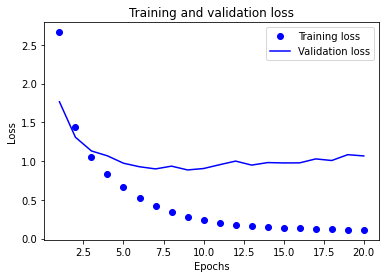

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Curva del accuracy. El sobreajuste comienza después de aproximadamente 8 épocas

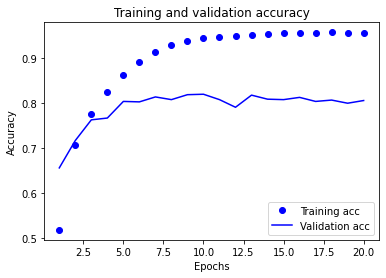

In [19]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Vuelva a entrenar con parada temprana después de 8 épocas y valide

``` python
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0,)
result = model.evaluate(x_test, one_hot_test_labels)
```

In [20]:
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0)
result = model.evaluate(x_test, one_hot_test_labels)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

71/71 [==============================] - 0s 3ms/step - loss: 1.3416 - accuracy: 0.7894
Loss: 1.3416, Accuracy: 0.7894


#### Cuello de botella de información
* ¿Qué sucede si creamos un cuello de botella de información a propósito?
    - Use solo 4 unidades ocultas en la segunda capa
* Accuracy cae dramáticamente!
* Estamos tratando de aprender 46 hiperplanos separadores de una representación de 4 dimensiones
    - Se las arregla para guardar mucha información, pero también pierde mucha
    
``` python
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
```

In [23]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128, verbose=0,
          validation_data=(x_val, y_val))
result = model.evaluate(x_test, one_hot_test_labels)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

71/71 [==============================] - 0s 3ms/step - loss: 1.9054 - accuracy: 0.6866
Loss: 1.9054, Accuracy: 0.6866


#### Qué cosas recordar de este ejemplo
* Para un problema con $C$ clases, la capa Dense final necesita $C$ unidades
* Utilizar la activación `softmax` y pérdida `categorical_crossentropy`
* Cuello de botella de información: al clasificar muchas clases, las capas ocultas deben ser lo suficientemente grandes
* Muchas opciones de diseño tienen un efecto sobre el accuracy y el sobreajuste. Probar:
    - 1 o 3 capas ocultas
    - más o menos unidades ocultas (por ejemplo, 128)

### Regresión
* Dataset: 506 ejemplos de casas y precios de venta ([Boston](https://www.kaggle.com/c/boston-housing))
    - Incluido en Keras, con una división de entrenamiento-prueba de 1/5
* Cada fila es un precio de la casa, descrito por propiedades numéricas de la casa y el vecindario
* Conjunto de datos pequeño, características no normalizadas

In [ ]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Preprocesamiento
* Las redes neuronales funcionan mucho mejor si primero normalizamos las características. 
* Keras no tiene soporte incorporado, por lo que tenemos que hacer esto manualmente (o con scikit-learn)
    - Nuevamente, tenga cuidado de no mirar los datos de prueba durante la normalización
    
``` python
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std
```

In [25]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

#### Construyendo la red
* Este es un conjunto de datos pequeño, muy fácil de sobreajustar
    * Usamos 2 capas ocultas de 64 unidades cada una
* Utilice lotes más pequeños, más épocas
* Como queremos una salida escalar, la capa de salida es una unidad sin activación
* Loss function es Mean Squared Error (mayor penalización)
* La métrica de evaluación es Mean Absolute Error (más interpretable)
* También usaremos cross-validation, así que envolvemos la construcción del modelo en una función, de modo que podamos llamarla varias veces

``` python
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model
```

In [26]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras no tiene soporte para cross-validation
* Podemos implementar cross-validation nosotros mismos (ver notebook)
* Generalmente hablando, cross-validation es complicado con las redes neuronales
    * Es posible que algunas dobladas no converjan o fluctúen en la inicialización aleatoria.

In [ ]:
#tarda 5min aprox.
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
print("MAE: ", np.mean(all_scores))

MAE:  2.4756230115890503


Entrena durante más tiempo (500 épocas) y realiza un seguimiento de las pérdidas después de cada época
(ver código en el notebook)

In [ ]:
#tarda como 25 min.
from keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


El modelo comienza a sobreajustarse después de la época 80.

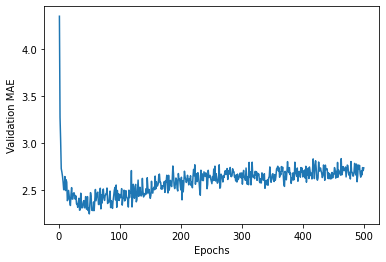

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Vuelva a entrenar con un número optimizado de épocas

``` python
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
```

In [ ]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print("MAE: ", test_mae_score)

4/4 [==============================] - 0s 4ms/step - loss: 17.4592 - mae: 2.6644
MAE:  2.664363384246826


#### Qué cosas recordar de este ejemplo 
* La regresión generalmente se realiza utilizando la pérdida de MSE y MAE para la evaluación
* Los datos de entrada siempre se deben escalar (independientemente del conjunto de prueba)
* Pequeños conjuntos de datos:
    - Utilizar cross-validation
    - Utilizar redes simples (non-deep)
    - Lotes más pequeños, más épocas

### Regularización: construir redes más pequeñas
* La forma más sencilla de evitar el sobreajuste es utilizar un modelo más sencillo
* El número de parámetros que se pueden aprender se llama el *capacity* del modelo.
* Un modelo con más parámetros tiene un mayor *memorization capacity*
    - El conjunto de entrenamiento completo se puede 'almacenar' en los pesos
    - Aprende el mapeo desde los ejemplos de entrenamiento a la salida deseada
* Forzar el modelo a ser pequeño lo obliga a aprender una representación comprimida que generaliza mejor
    - Siempre una compensación entre demasiado y muy poca capacidad
* Comience con pocas capas y parámetros, aumente hasta que vea rendimientos decrecientes

Probemos esto con nuestros datos de reseñas de películas, con 4 unidades por capa

``` python
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
from tensorflow.keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers 

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512, verbose=0,
                                   validation_data=(x_test, y_test))
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512, verbose=0,
                                       validation_data=(x_test, y_test))

El modelo más pequeño comienza a sobreajustarse más tarde que el original, y se sobreajusta más *lentamente*

In [ ]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

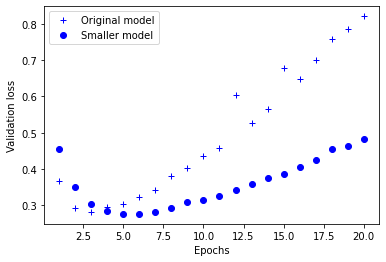

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### Regularización: regularización de peso
* Como hicimos muchas veces antes, también podemos agregar la regularización de peso a nuestra función de pérdida.
- Regularización L1 : lleva a *sparse networks* con muchos pesos que son 0
- Regularización L2 : conduce a muchos pesos muy pequeños
    - También llamado *weight decay* en la literatura de redes neuronales
* En Keras, agregue `kernel_regularizer` a cada capa

``` python
from tensorflow.keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [ ]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=0,
                             validation_data=(x_test, y_test))

El modelo regularizado L2 es mucho más resistente al sobreajuste, aunque ambos tienen el mismo número de parámetros

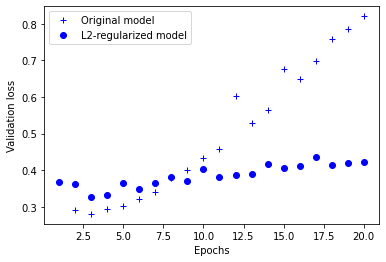

In [ ]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

También puede probar la pérdida L1 o ambas al mismo tiempo
``` python
from tensorflow.keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```

### Regularización: dropout
* Una de las técnicas de regularización más eficaces y utilizadas
* Establecer aleatoriamente una cantidad de salidas de la capa en 0
* Idea: romper patrones aprendidos accidentales no significativos 
* *Dropout rate*: fracción de las salidas que se ponen a cero
    - Usualmente entre 0.2 y 0.5
* En el momento de la prueba, no se descarta nada, pero los valores de salida se reducen según la tasa de dropout.
    - Equilibra que hay más unidades activas que durante el entrenamiento
* En Keras: agrega (add) capas `Dropout` entre las capas normales

![](https://drive.google.com/uc?id=1oLYMwj7ars6bVWUxAgsV4tWMsvjOgdQT)

``` python
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
```

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers 

dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [ ]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512, verbose=0,
                               validation_data=(x_test, y_test))

Dropout encuentra un modelo mejor y se sobreajusta más lentamente también

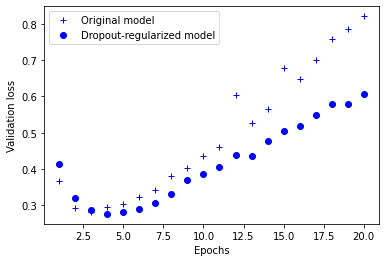

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### Regularización (resumen)
* Obtener más datos de entrenamiento
* Reducir la capacidad de la red
* Agregar regularización de peso
* Agregar dropout
* Comience con un modelo simple y agregue capacidad
* O, comenzar con un modelo complejo y luego regularizar agregando regularización de peso y dropout

## Word Embeddings
* Un embedding mapea cada palabra a un punto en un espacio n-dimensional (por ejemplo, 300 valores), de modo que palabras similares estén cerca unas de otras
* Hay diferentes formas de aprender word embeddings. Los más comunes son:
    * Word2Vec: Aprenda a codificar según las palabras que normalmente se encuentran en una ventana alrededor de la palabra
        * La codificación se aprende utilizando una red neuronal de 1 capa
    * GloVe (Global Vector): Contar co-ocurrencias de palabras en una matriz
        * Utilice una aproximación de rango bajo para obtener una representación vectorial condensada
    * FastText: aprende embedding para n-gramas en lugar de palabras completas
        * También se puede producir embeddings para palabras nuevas
    * BERT, ELMO,...: aprender un embedding contexto-dependiente: una palabra tiene un embedding diferente dependiendo de la oración o frase que aparece

### Word embeddings: Word2Vec and GloVe

![](https://drive.google.com/uc?id=1lNhDZXed1l1jzhIVAi9mT8fA9XhUysSF)

### Word2Vec
- Continuous bag of words (CBOW): entrenar un modelo para predecir una palabra dado el contexto, use pesos de la última capa como embedding
- Skip-Gram: entrenar modelo para predecir el contexto dado una palabra, usar pesos de la primera capa como embedding (mejor para grandes corpora)

![](https://drive.google.com/uc?id=1TxDLccaDjB-Xh98pgNJdJa19nm4u4p6a)

### FastText
Como CBOW o SkipGram, pero usando n-gramas en vez de palabras

![](https://drive.google.com/uc?id=1ImR0-sRD5MszqE69Foxp1C8lXuPx-Kgm)

### BERT, ELMO, GPT,...
* Utilice las redes de [transformadores](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)) para aprender las embeddings contextuales
* Devlin et al. (2018) [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://www.aclweb.org/anthology/N19-1423.pdf)

![](https://drive.google.com/uc?id=1WusCGgXii28-x4dsI7n6bPmyySYrirSR)

## Usando Embeddings en Keras
* Utiliza un embedding previamente entrenada, obtenida con GloVe
* Ver un completo ejemplo [acá](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

``` python
max_length = 20 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 300 # vocabulary size
# define the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
```